In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import copy
import itertools
from utils_graphs import select_significant_areas, create_graph, plot_graph, get_colors, fig_graph_degrees
import utils_PLS as upls
import matplotlib.colors as cm
from matplotlib.lines import Line2D

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_c57.npy', allow_pickle=True).item()
subjects = list(dict_results_across_mice.keys())
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

In [4]:
df_control_cell_count

,area,F10Control,F16Control,F11Control,F1Control
0,Frontal pole cerebral cortex,59,23,106,105
1,Primary motor area,1447,41,155,259
2,Secondary motor area,2448,219,587,1448
3,Primary somatosensory area,2755,444,377,1442
4,Supplemental somatosensory area,1055,122,403,493
...,...,...,...,...,...
194,Interfascicular nucleus raphe,1,0,0,0
195,Interpeduncular nucleus,3,0,0,0
196,Rostral linear nucleus raphe,0,0,0,0
197,Central linear nucleus raphe,1,0,0,0


In [5]:
corr_threshold = 0.75
allen_order = list(volumes[volumes['st_level']==8]['acronym'])

In [6]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


In [7]:
df_levels = upls.create_df_levels(volumes)

# TODOs: 
1) grandezza nodi per fold change

2) PLS e fare ranking delle saliences

3) Grafi da aree PLS

4) Grafi con le aree anticorrelate (X)

5) Correlazione e grafi con energia da confrontare con grafi n cellule

6) Grafi con layout spring

# Graphs of positive correlations

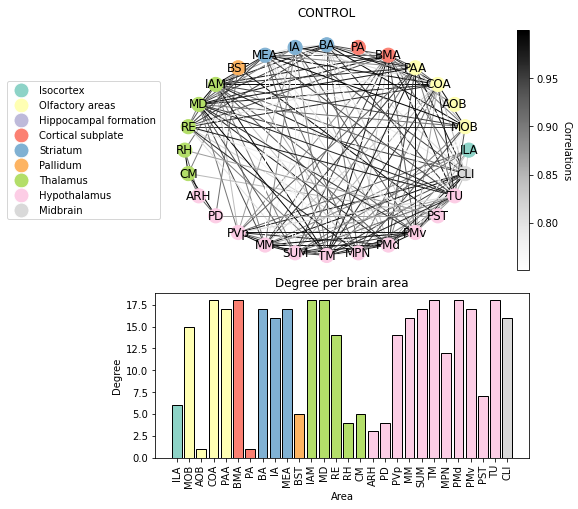

In [9]:
fig_graph_degrees(G=G_control, title='CONTROL', volumes=volumes)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graphs_ncells_ttest_control.svg')

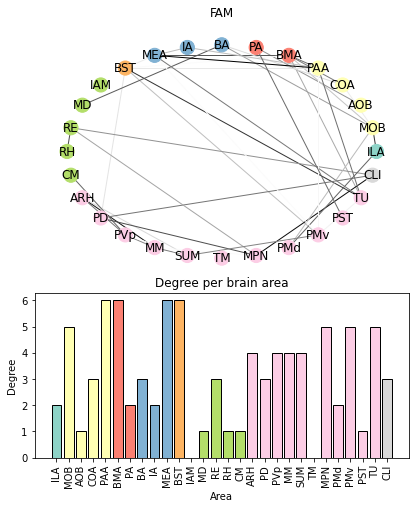

In [10]:
fig_graph_degrees(G=G_fam, title='FAM', volumes=volumes, show_colorbar=False, show_legend=False)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graphs_ncells_ttest_fam.svg')

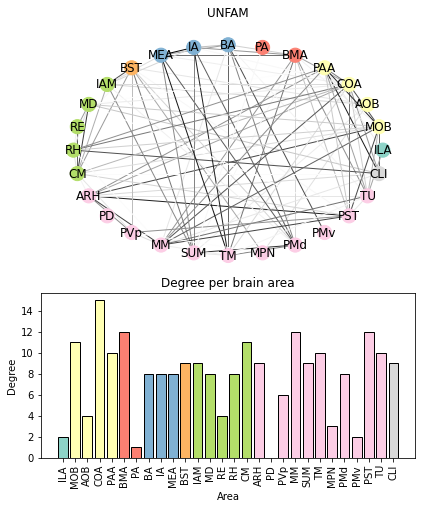

In [11]:
fig_graph_degrees(G=G_unfam, title='UNFAM', volumes=volumes, show_colorbar=False, show_legend=False)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graphs_ncells_ttest_unfam.svg')

## Using Spring layout

## Histogram degrees

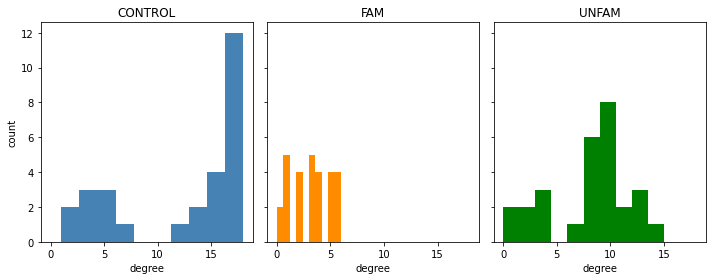

In [11]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('CONTROL')
axes[0].hist(list(dict(G_control.degree).values()),
            color='steelblue')
axes[1].set_title('FAM')
axes[1].hist(list(dict(G_fam.degree).values()),
            color='darkorange')
axes[2].set_title('UNFAM')
axes[2].hist(list(dict(G_unfam.degree).values()),
            color='green')
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.png')

Text(0, 0.5, 'Degree')

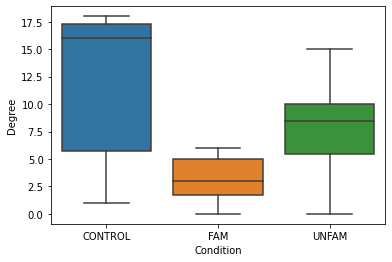

In [12]:
df_boxplot = pd.DataFrame({'CONTROL':list(dict(G_control.degree).values()), 
                           'FAM': list(dict(G_fam.degree).values()), 
                           'UNFAM':list(dict(G_unfam.degree).values())})
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_boxplot, ax=ax)
ax.set_xlabel('Condition')
ax.set_ylabel('Degree')

## Histogram weights

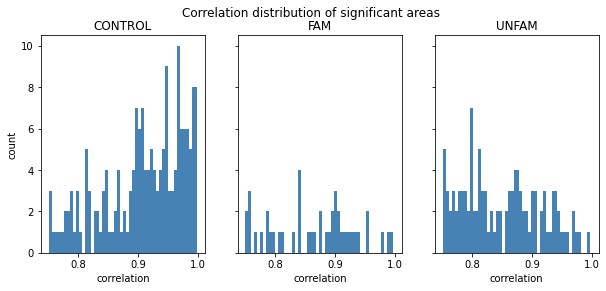

In [13]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for i, G in enumerate([G_control, G_fam, G_unfam]):
    axes[i].hist([G[u][v]['weight'] for u, v in G.edges],
            color='steelblue', bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlation distribution of significant areas')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation.png')

# Overall correlations

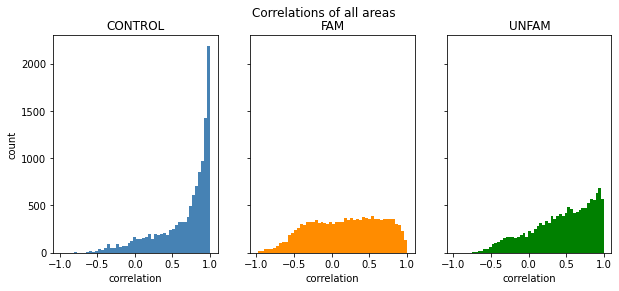

In [14]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
colors = ['steelblue', 'darkorange', 'green']
for i, corr in enumerate([corr_matrix_control_ncells, 
                          corr_matrix_fam_ncells, 
                          corr_matrix_unfam_ncells]):
    axes[i].hist(corr.mask(np.triu(np.ones(corr.shape)).astype(bool)).stack().values,
            color=colors[i], bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlations of all areas')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_all.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_all.png')

# Positive and negative correlations

In [15]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


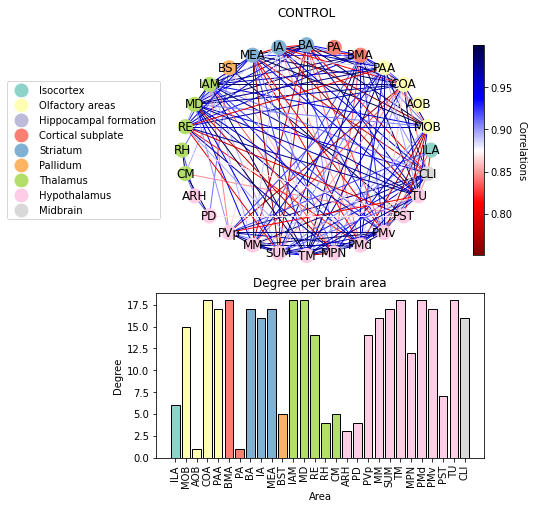

In [16]:
fig = plt.figure("control", figsize=(7, 8))
plt.subplots_adjust(left=0.25)
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')
# plot graph
ax0 = fig.add_subplot(axgrid[0:3, :])

plot_graph(G=G_control,order=allen_order, volumes=volumes, df_levels=df_levels, ax=ax0, title='CONTROL',
          edge_cmap = plt.cm.get_cmap('seismic_r'))

colors_dict = get_colors(G_control, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
areas = sorted(list(G_control.nodes()), key = allen_order.index)
degrees = [G_control.degree()[area] for area in areas]
# plot degrees
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees)

for idx, color in enumerate(get_colors(G_control, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

legend_elements = [Line2D([0], [0], marker='o', color='w', label=area,
                          markerfacecolor=colors_dict[area], markersize=15) \
                   for area in colors_dict.keys()]

# Create the legend
ax0.legend(handles=legend_elements, loc='right', bbox_to_anchor=(0.03,0.5))

# colorbar
weights = [G_control[u][v]['weight'] for u, v in G_control.edges]
color_weights=np.array(weights)
cmap=edge_cmap
vmin = min(weights)
vmax = max(weights)
sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

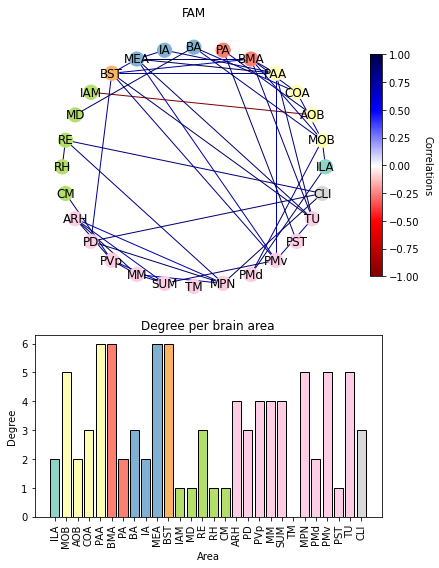

In [17]:
fig = plt.figure("fam", figsize=(5.5, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_fam,order=allen_order, volumes=volumes, df_levels=df_levels, ax=ax0, title='FAM',
          edge_cmap = edge_cmap)

areas = sorted(list(G_fam.nodes()), key = allen_order.index)
degrees = [G_fam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')

for idx, color in enumerate(get_colors(G_fam, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()
# colorbar
weights = [G_fam[u][v]['weight'] for u, v in G_fam.edges]
color_weights=np.array(weights)
cmap=edge_cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

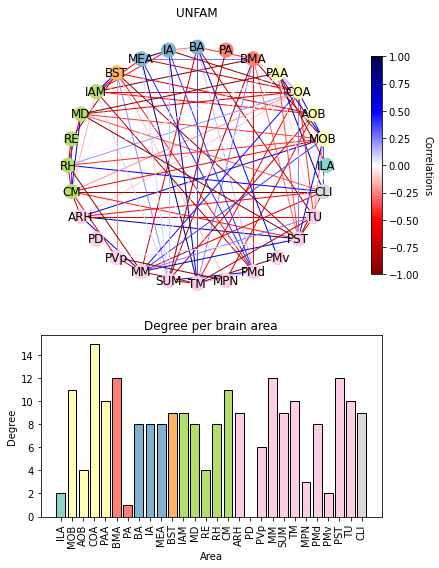

In [18]:
fig = plt.figure("unfam", figsize=(5.5, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_unfam,order=allen_order, volumes=volumes, df_levels=df_levels, ax=ax0, title='UNFAM',
          edge_cmap=edge_cmap)

areas = sorted(list(G_unfam.nodes()), key = allen_order.index)
degrees = [G_unfam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')

for idx, color in enumerate(get_colors(G_unfam, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

# colorbar
weights = [G_unfam[u][v]['weight'] for u, v in G_unfam.edges]
color_weights=np.array(weights)
cmap=edge_cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

# Fare grafi scegliendo i nodi con la PLS

In [12]:
pls_sig_areas = np.load('results_pls/pls_sig_areas_c57.npy', allow_pickle=True)

In [13]:
G_control_pls = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.9, correlations='one')
G_fam_pls = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.9, correlations='one')
G_unfam_pls = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=pls_sig_areas, 
                         corr_threshold=0.9, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


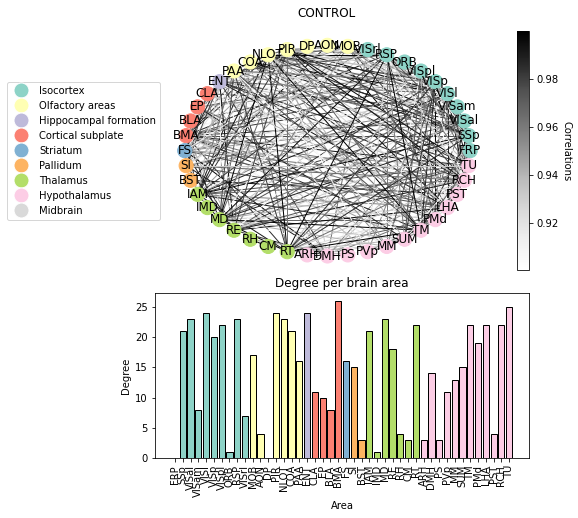

In [19]:
fig_graph_degrees(G=G_control_pls, title='CONTROL', volumes=volumes)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graphs_ncells_pls_control.svg')

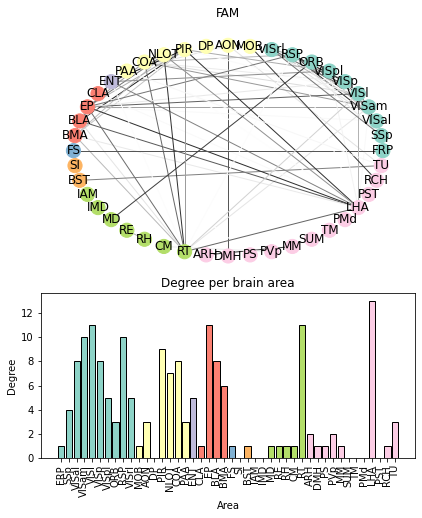

In [18]:
fig_graph_degrees(G=G_fam_pls, title='FAM', volumes=volumes, show_legend=False, show_colorbar=False)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graphs_ncells_pls_fam.svg')

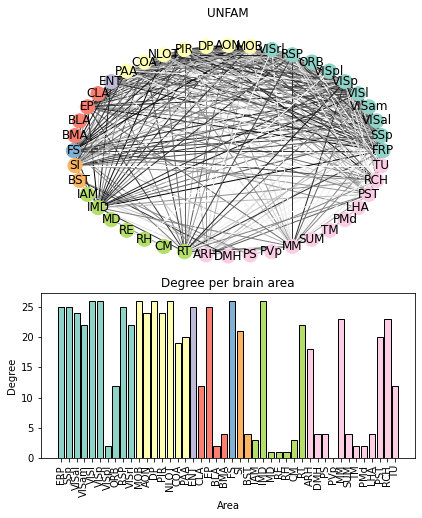

In [17]:
fig_graph_degrees(G=G_unfam_pls, title='UNFAM', volumes=volumes, show_legend=False, show_colorbar=False)
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graphs_ncells_pls_unfam.svg')

## Save significant areas

In [24]:
ordered_areas = sorted(sig_areas_ncells_ttest, 
                       key = list(volumes[volumes['st_level']==8]['safe_name'])
.index)
dictionary_labels = {volumes.loc[volumes['safe_name'] == area]['acronym'].values[0]:area\
                     for area in ordered_areas}
df_areas = pd.DataFrame.from_dict(dictionary_labels, orient='index')
df_areas.columns = ['area']
df_areas.to_csv('significant_areas.csv')

# Look at betweenness for graphs

Text(0, 0.5, 'Average Betweenness Centrality')

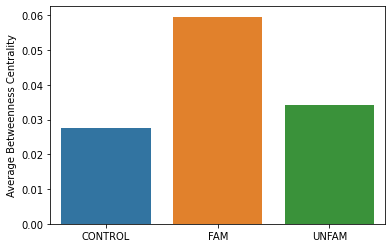

In [62]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
betweenness_centrality = [nx.betweenness_centrality(G) for G in graphs]
df_betweenness_centrality = pd.DataFrame({'CONTROL': [np.mean(list(betweenness_centrality[0].values()))], 
                                'FAM': [np.mean(list(betweenness_centrality[1].values()))],
                                'UNFAM': [np.mean(list(betweenness_centrality[2].values()))]})
sns.barplot(data=df_betweenness_centrality, ax=axes)
axes.set_ylabel('Average Betweenness Centrality')

Text(0, 0.5, 'Average Betweenness Centrality')

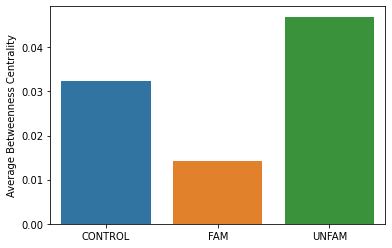

In [63]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
betweenness_centrality = [nx.betweenness_centrality(G) for G in graphs]
df_betweenness_centrality = pd.DataFrame({'CONTROL': [np.mean(list(betweenness_centrality[0].values()))], 
                                'FAM': [np.mean(list(betweenness_centrality[1].values()))],
                                'UNFAM': [np.mean(list(betweenness_centrality[2].values()))]})
sns.barplot(data=df_betweenness_centrality, ax=axes)
axes.set_ylabel('Average Betweenness Centrality')

In [25]:
def plot_betweenness(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        betweenness = [nx.betweenness_centrality(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= betweenness)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes)[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Betweenness")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

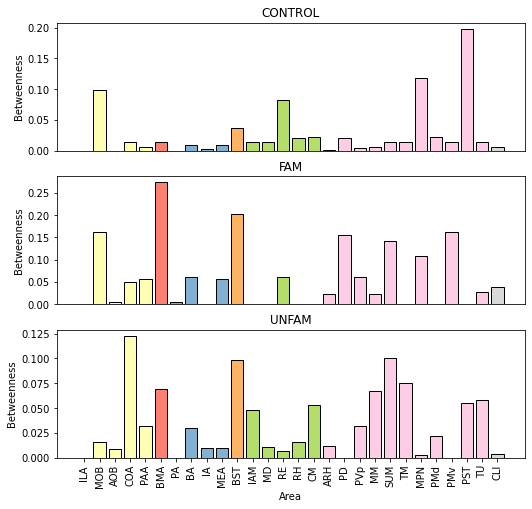

In [26]:
plot_betweenness(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

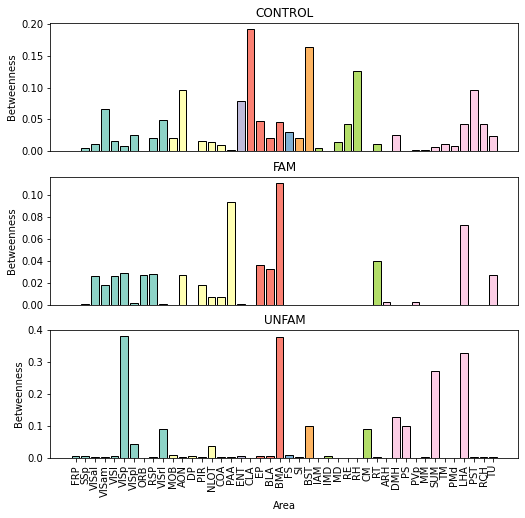

In [27]:
plot_betweenness(graphs=[G_control_pls, G_fam_pls, G_unfam_pls], volumes=volumes)


# Order the betweenness

In [28]:
# graphs = [G_control, G_fam, G_unfam]
# graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
# # create tables
# allen_order = list(volumes[volumes['st_level']==8]['acronym'])
# df_levels = upls.create_df_levels(volumes)
# sort=True
# # create figure
# fig, axes = plt.subplots(3,1, figsize=(10, 8))
# plt.subplots_adjust(left=0.25)
# for i, G in enumerate(graphs):
#     colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
#     if sort:
#         betweenness = nx.betweenness_centrality(G)
#         sorted_betweenness = sorted(betweenness.items(), key=lambda x:x[1], reverse=True)
#         betweenness = list(dict(sorted_betweenness).values())
#         areas = list(dict(sorted_betweenness).keys())
#     else:
#         areas = sorted(list(G.nodes()), key = allen_order.index)
#         betweenness = [nx.betweenness_centrality(G)[area] for area in areas]

#     # plot degrees
#     axes[i].bar(x= areas, 
#             height= betweenness)

#     for idx, color in enumerate(get_colors(G, 
#                                            df_levels=df_levels, 
#                                            order=allen_order,
#                                            sorting=True,
#                                            volumes=volumes)[0]):
#         axes[i].get_children()[idx].set_color(color) 
#         axes[i].get_children()[idx].set_edgecolor('black')
#     axes[i].set_title(graphs_titles[i])
#     axes[i].set_ylabel("Betweenness")
#     axes[i].set_xlabel('')
#     if i in [0,1]:
#         axes[i].set_xticks([])
# axes[2].set_xlabel("Area")
# axes[2].tick_params(axis='x', labelrotation=90)

# Look at degree centrality


The degree centrality for a node v is the fraction of nodes it is connected to.

Text(0, 0.5, 'Average degree Centrality')

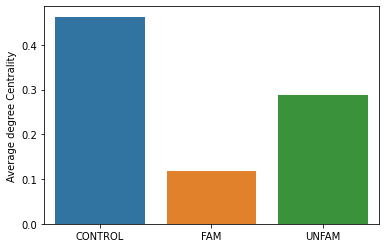

In [60]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
degree_centrality = [nx.degree_centrality(G) for G in graphs]
df_degree_centrality = pd.DataFrame({'CONTROL': [np.mean(list(degree_centrality[0].values()))], 
                                'FAM': [np.mean(list(degree_centrality[1].values()))],
                                'UNFAM': [np.mean(list(degree_centrality[2].values()))]})
sns.barplot(data=df_degree_centrality, ax=axes)
axes.set_ylabel('Average degree Centrality')

Text(0, 0.5, 'Average degree Centrality')

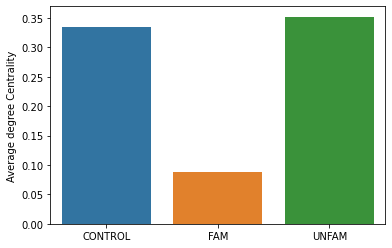

In [61]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
degree_centrality = [nx.degree_centrality(G) for G in graphs]
df_degree_centrality = pd.DataFrame({'CONTROL': [np.mean(list(degree_centrality[0].values()))], 
                                'FAM': [np.mean(list(degree_centrality[1].values()))],
                                'UNFAM': [np.mean(list(degree_centrality[2].values()))]})
sns.barplot(data=df_degree_centrality, ax=axes)
axes.set_ylabel('Average degree Centrality')

In [29]:
def plot_degree_centrality(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        degree_centrality = [nx.degree_centrality(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= degree_centrality)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes)[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Degree Centrality")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

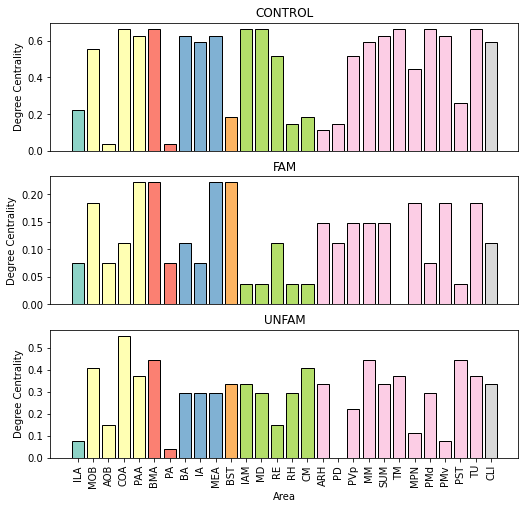

In [30]:
plot_degree_centrality(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

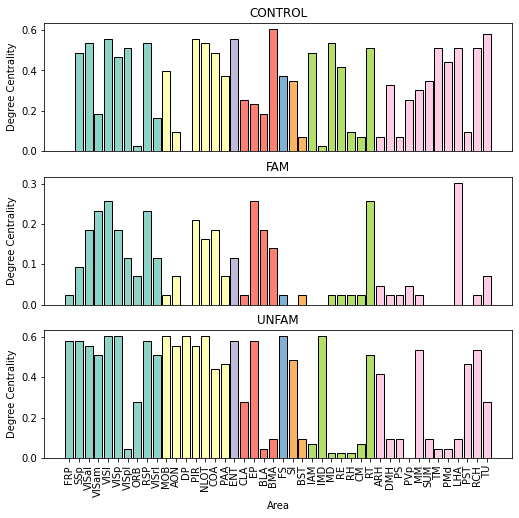

In [31]:
plot_degree_centrality(graphs=[G_control_pls, G_fam_pls, G_unfam_pls], volumes=volumes)

# Efficiency

The efficiency of a pair of nodes in a graph is the multiplicative inverse of the shortest path distance between the nodes. The average global efficiency of a graph is the average efficiency of all pairs of nodes

Text(0, 0.5, 'Global efficiency')

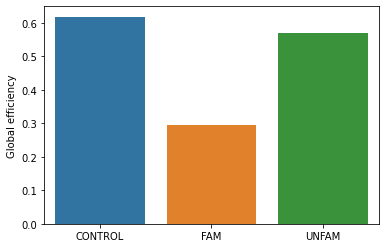

In [44]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
efficiencies = [nx.global_efficiency(G) for G in graphs]
df_efficiencies = pd.DataFrame({'CONTROL': [efficiencies[0]], 
                                'FAM': [efficiencies[1]],
                                'UNFAM': [efficiencies[2]]})
sns.barplot(data=df_efficiencies, ax=axes)
axes.set_ylabel('Global efficiency')

Text(0, 0.5, 'Global efficiency')

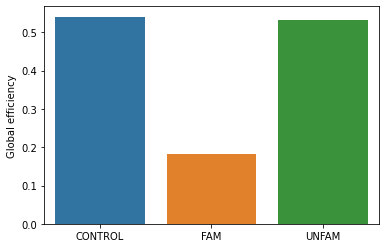

In [45]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
efficiencies = [nx.global_efficiency(G) for G in graphs]
df_efficiencies = pd.DataFrame({'CONTROL': [efficiencies[0]], 
                                'FAM': [efficiencies[1]],
                                'UNFAM': [efficiencies[2]]})
sns.barplot(data=df_efficiencies, ax=axes)
axes.set_ylabel('Global efficiency')

# Clustering

For weighted graphs, there are several ways to define clustering [1]. the one used here is defined as the geometric average of the subgraph edge weights [2],

Text(0, 0.5, 'Clustering')

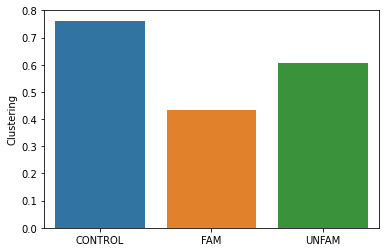

In [55]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
clustering = [nx.clustering(G) for G in graphs]
df_clustering = pd.DataFrame({'CONTROL': [np.mean(list(clustering[0].values()))], 
                                'FAM': [np.mean(list(clustering[1].values()))],
                                'UNFAM': [np.mean(list(clustering[2].values()))]})
sns.barplot(data=df_clustering, ax=axes)
axes.set_ylabel('Clustering')

Text(0, 0.5, 'Clustering')

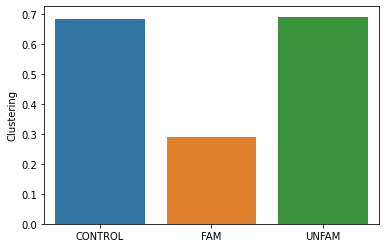

In [56]:
fig, axes = plt.subplots(1,1)
graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
clustering = [nx.clustering(G) for G in graphs]
df_clustering = pd.DataFrame({'CONTROL': [np.mean(list(clustering[0].values()))], 
                                'FAM': [np.mean(list(clustering[1].values()))],
                                'UNFAM': [np.mean(list(clustering[2].values()))]})
sns.barplot(data=df_clustering, ax=axes)
axes.set_ylabel('Clustering')

In [57]:
def plot_clustering(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        clustering = [nx.clustering(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= clustering)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes)[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Clustering Coefficient")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

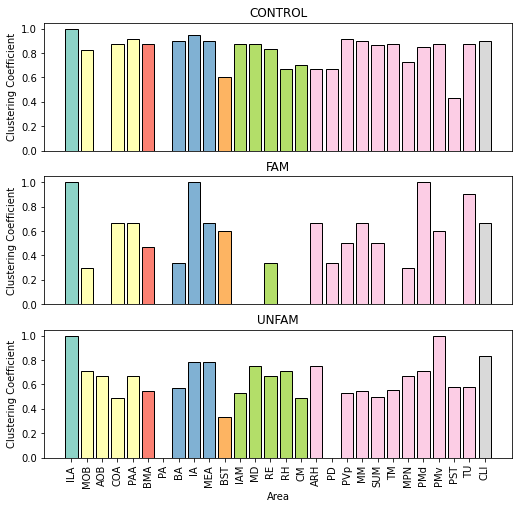

In [58]:
plot_clustering(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

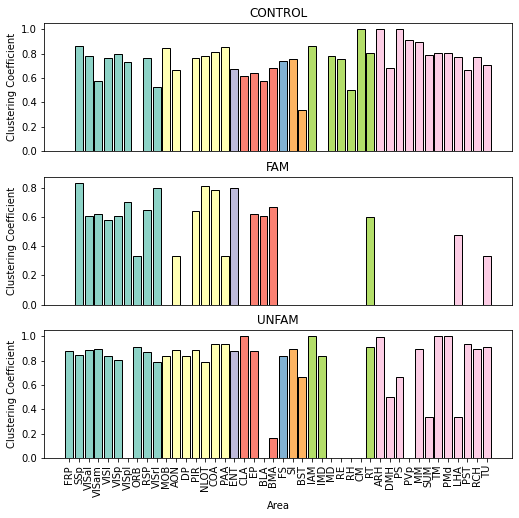

In [59]:
plot_clustering(graphs=[G_control_pls, G_fam_pls, G_unfam_pls], volumes=volumes)